Dropping all-NaN engineered columns: ['debt_to_income']


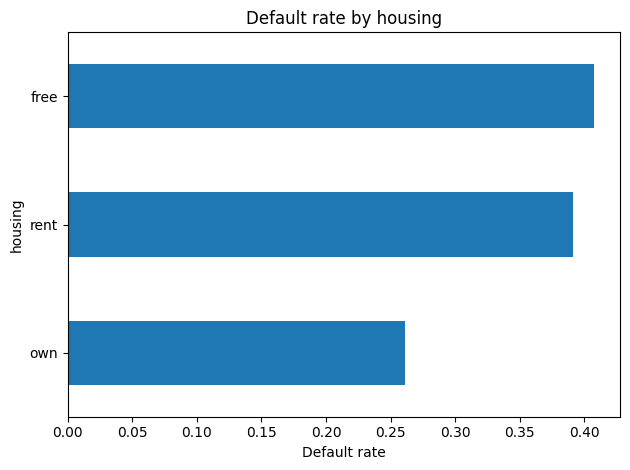

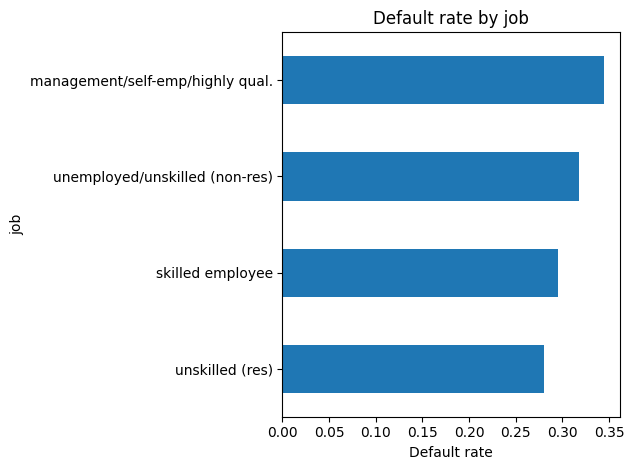

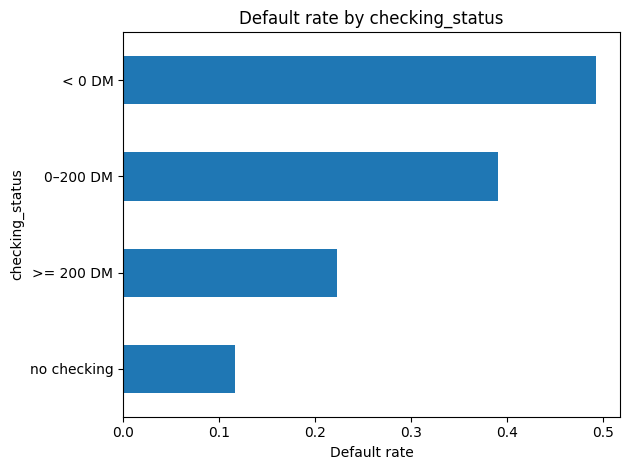

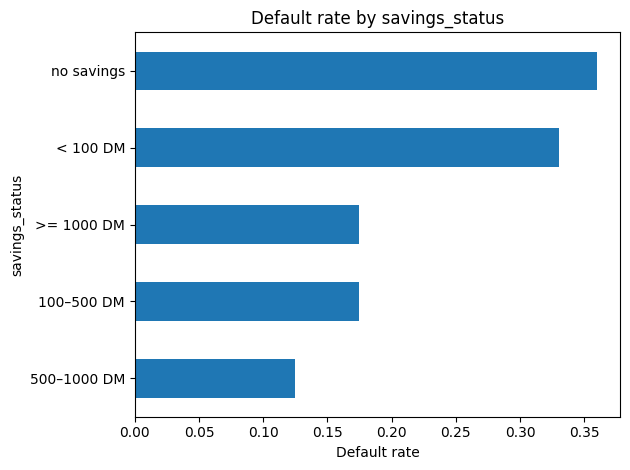

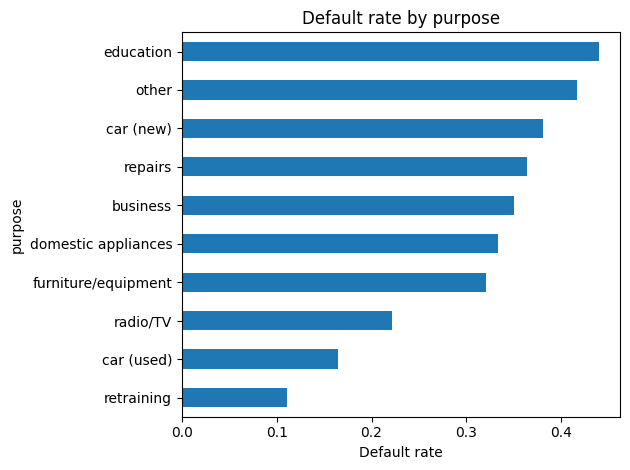

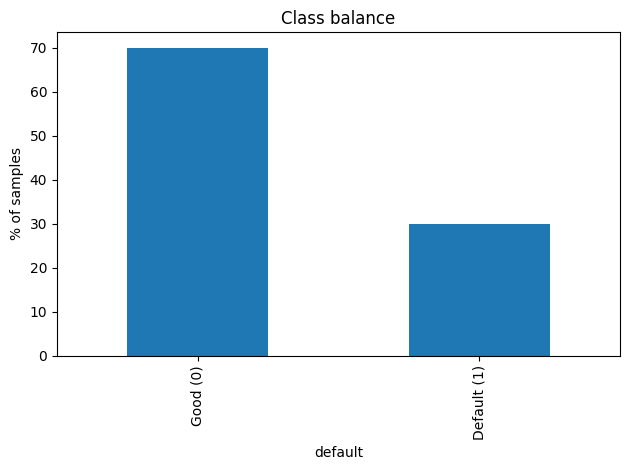

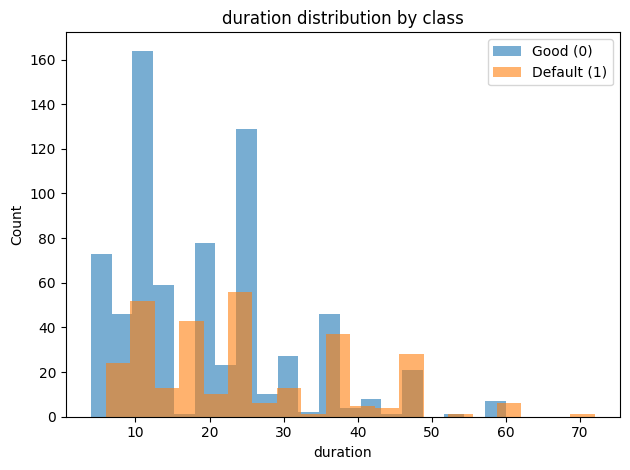

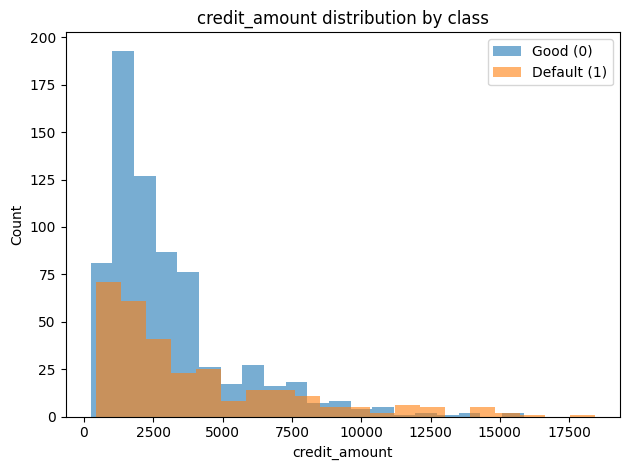

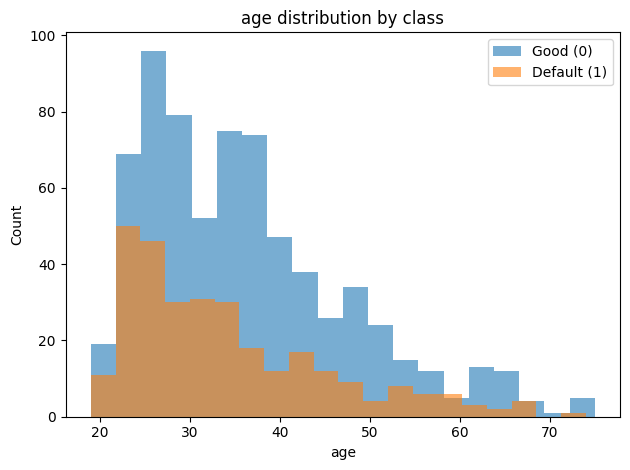

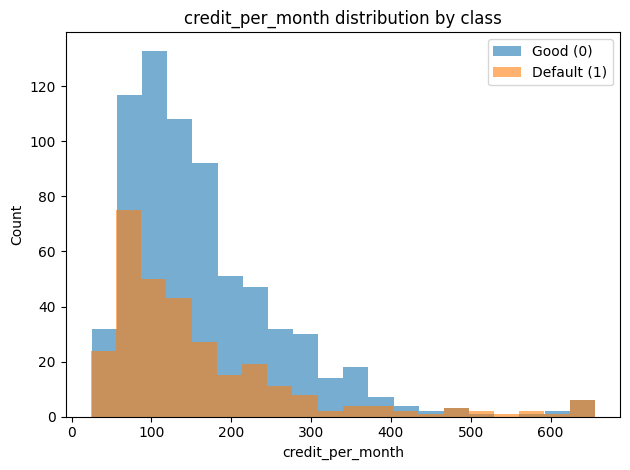

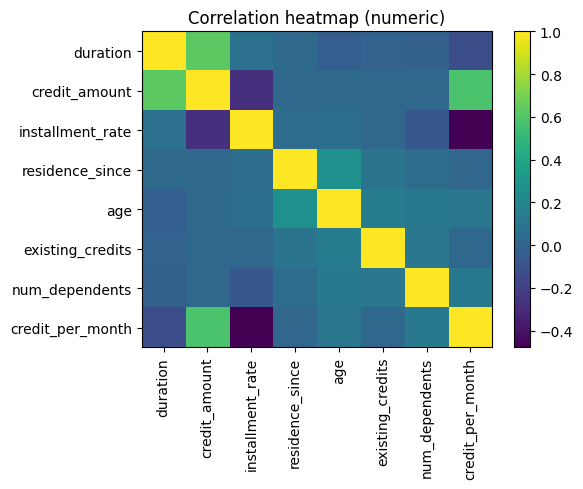


Confusion matrix @ final threshold (0.234)
[[71 69]
 [ 7 53]]
TN=71  FP=69  FN=7  TP=53
Precision=0.434  Recall=0.883  F1=0.582  Acc=0.620  TNR(Specificity)=0.507  FPR=0.493
Row-normalized (by true class):
 [[0.507 0.493]
 [0.117 0.883]]


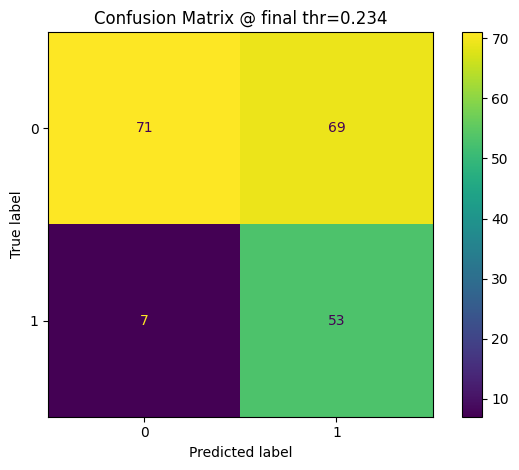


Confusion matrix @ 0.5 threshold (0.500)
[[134   6]
 [ 37  23]]
TN=134  FP=6  FN=37  TP=23
Precision=0.793  Recall=0.383  F1=0.517  Acc=0.785  TNR(Specificity)=0.957  FPR=0.043
Row-normalized (by true class):
 [[0.957 0.043]
 [0.617 0.383]]


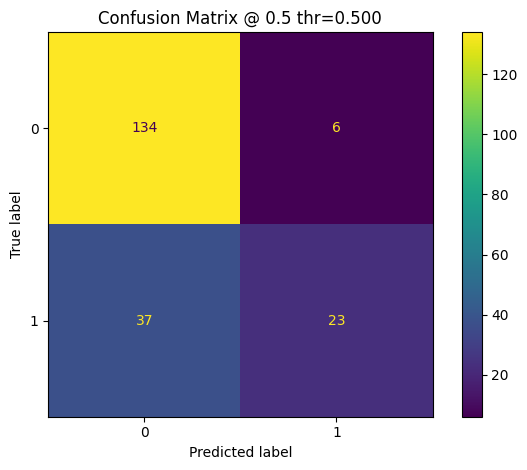

Chosen model: RF | Val AUC=0.747 | Val F1=0.603
Test @0.5   : AUC=0.812  P=0.793 R=0.383  F1=0.517
Test @final : thr=0.234  AUC=0.812  P=0.434 R=0.883  F1=0.582
Data quality check passed: no NaN/Inf reaching the model.
Saved model_final_pipeline.joblib, threshold.joblib, metrics.txt


In [1]:
# Credit Risk Scoring: End-to-End Baseline (LogReg + RandomForest)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    precision_recall_curve
)
from sklearn.base import clone
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay
import joblib

SEED = 42
np.random.seed(SEED)

# Load data
CANDIDATES = [
    Path("german_credit_data.csv"),
    Path("data/german_credit_data.csv"),
    Path("C:/Users/José Paz Donayre/Documents/credit-risk-model/german_credit_data.csv"),
]
DATA_PATH = next((p for p in CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Couldn't find 'german_credit_data.csv'. Place it next to the notebook or update DATA_PATH."
    )
df_raw = pd.read_csv(DATA_PATH)

# Harmonize schema & target
df = df_raw.copy()
target_col = None
for cand in ["Risk", "default", "Default", "class", "Class", "target", "Target"]:
    if cand in df.columns:
        target_col = cand
        break
if target_col is None:
    raise ValueError("Target column not found. Expected one of: Risk, default, class, target")

# Map to binary 1=default, 0=good
y = df[target_col].copy()
if y.dtype == object:
    y = y.str.lower().map({"bad": 1, "good": 0})
elif sorted(pd.unique(y)) == [1, 2]:
    y = y.map({1: 0, 2: 1})
# else assume already 0/1

if y.isna().any():
    raise ValueError("Target mapping produced NaNs. Inspect your target column values.")

X = df.drop(columns=[target_col])
X = X.rename(columns={c: c.lower().replace(" ", "_") for c in X.columns})

# Readable labels
label_maps = {
    "checking_status": {
        "A11": "< 0 DM", "A12": "0–200 DM", "A13": ">= 200 DM", "A14": "no checking"
    },
    "savings_status": {
        "A61": "no savings", "A62": "< 100 DM", "A63": "100–500 DM",
        "A64": "500–1000 DM", "A65": ">= 1000 DM"
    },
    "credit_history": {
        "A30": "no credits/paid",
        "A31": "all paid duly",
        "A32": "existing paid duly",
        "A33": "delayed previously",
        "A34": "critical/other existing"
    },
    "purpose": {
        "A40": "car (new)", "A41": "car (used)", "A42": "furniture/equipment", "A43": "radio/TV",
        "A44": "domestic appliances", "A45": "repairs", "A46": "education", "A47": "vacation",
        "A48": "retraining", "A49": "business", "A410": "other"
    },
    "housing": { "A151": "rent", "A152": "own", "A153": "free" },
    "job": {
        "A171": "unemployed/unskilled (non-res)",
        "A172": "unskilled (res)",
        "A173": "skilled employee",
        "A174": "management/self-emp/highly qual."
    },
    "property_magnitude": {
        "A121": "real estate", "A122": "life insurance", "A123": "car/other", "A124": "unknown/none"
    },
    "other_debtors": { "A101": "none", "A102": "co-applicant", "A103": "guarantor" },
    "telephone": { "A191": "none", "A192": "yes (registered)" },
    "foreign_worker": { "A201": "yes", "A202": "no" },
    "employment": {
        "A71": "unemployed",
        "A72": "<=1y",
        "A73": "1-4y",
        "A74": "4-7y",
        "A75": ">=7y"
    }
}

for col, mapping in label_maps.items():
    if col in X.columns:
        X[col] = X[col].map(lambda v: mapping.get(v, v))
        if col in df.columns:
            df[col] = df[col].map(lambda v: mapping.get(v, v))

# Feature Engineering
# Identify common numeric fields across variants
credit_amt_candidates = [c for c in X.columns if "credit_amount" in c or c == "credit_amount" or (("credit" in c) and ("amount" in c))]
duration_candidates    = [c for c in X.columns if c == "duration" or "duration" in c]
age_candidates         = [c for c in X.columns if c == "age"]
income_candidates      = [c for c in X.columns if "income" in c or "salary" in c]

credit_col  = credit_amt_candidates[0] if credit_amt_candidates else None
duration_col= duration_candidates[0] if duration_candidates else None
age_col     = age_candidates[0] if age_candidates else None
income_col  = income_candidates[0] if income_candidates else None

X_fe = X.copy()
if credit_col and duration_col:
    X_fe["credit_per_month"] = X_fe[credit_col] / X_fe[duration_col].replace({0: np.nan})
else:
    X_fe["credit_per_month"] = np.nan

if income_col and credit_col:
    X_fe["debt_to_income"] = X_fe[credit_col] / X_fe[income_col].replace({0: np.nan})
else:
    X_fe["debt_to_income"] = np.nan

# Clip extreme ratios to reduce leverage
for c in ["credit_per_month", "debt_to_income"]:
    if c in X_fe.columns and X_fe[c].notna().any():
        hi = X_fe[c].quantile(0.99)
        if np.isfinite(hi) and hi > 0:
            X_fe[c] = X_fe[c].clip(upper=hi)

if age_col:
    X_fe["age_bucket"] = pd.cut(
        X_fe[age_col], bins=[0, 25, 40, 60, 120],
        labels=["18-25", "26-40", "41-60", "60+"], include_lowest=True
    )

# Sync engineered features to df (for EDA)
for c in ["credit_per_month", "debt_to_income", "age_bucket"]:
    if c in X_fe.columns:
        df[c] = X_fe[c]

# Clean engineered features (remove inf/NaN-only columns in both X_fe and df)
X_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
engineered = ["credit_per_month", "debt_to_income", "age_bucket"]
drop_cols = [c for c in engineered if c in X_fe.columns and X_fe[c].notna().sum() == 0]
if drop_cols:
    print("Dropping all-NaN engineered columns:", drop_cols)
    X_fe.drop(columns=drop_cols, inplace=True)
    for c in drop_cols:
        if c in df.columns:
            df.drop(columns=[c], inplace=True)

# Ensure a consistent binary target column on df for EDA
TARGET_COL = "default"
df[TARGET_COL] = y.astype(int).values
if target_col != TARGET_COL:
    df.drop(columns=[target_col], inplace=True, errors="ignore")

# EDA
# Category-Level Default Rates
cats_to_check = ["housing", "job", "checking_status", "savings_status", "purpose"]
if TARGET_COL in df.columns:
    for col in [c for c in cats_to_check if c in df.columns]:
        rates = df.groupby(col)[TARGET_COL].mean().sort_values()
        plt.figure()
        rates.plot(kind="barh")
        plt.xlabel("Default rate")
        plt.title(f"Default rate by {col}")
        plt.tight_layout()
        plt.show()

# Class imbalance
if TARGET_COL in df.columns:
    ax = df[TARGET_COL].value_counts(normalize=True).sort_index().mul(100).plot(kind="bar")
    ax.set_xticklabels(["Good (0)", "Default (1)"])
    ax.set_ylabel("% of samples")
    ax.set_title("Class balance")
    plt.tight_layout()
    plt.show()

# Numeric distributions by class
if TARGET_COL in df.columns:
    numeric_cols_df = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL, errors="ignore")
    num_cols_small = [c for c in numeric_cols_df if df[c].nunique() > 5][:6]
    for c in num_cols_small:
        plt.figure()
        df[df[TARGET_COL] == 0][c].plot(kind="hist", bins=20, alpha=0.6, label="Good (0)")
        df[df[TARGET_COL] == 1][c].plot(kind="hist", bins=20, alpha=0.6, label="Default (1)")
        plt.title(f"{c} distribution by class")
        plt.xlabel(c); plt.ylabel("Count"); plt.legend(); plt.tight_layout()
        plt.show()

# Correlation heatmap (numeric)
if TARGET_COL in df.columns:
    numeric_cols_df = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL, errors="ignore")
    corr = df[numeric_cols_df].corr()
    plt.figure(figsize=(6, 5))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation heatmap (numeric)")
    plt.tight_layout()
    plt.show()

# Split for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=SEED
)

# Column lists from TRAIN (for model pipelines)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Be compatible with sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols),
])

# Unified modeling & selection
def best_f1_threshold(y_true, y_prob):
    p, r, thr = precision_recall_curve(y_true, y_prob)   # len(thr) = len(p) - 1
    f1 = 2 * p * r / (p + r + 1e-9)
    idx = int(np.nanargmax(f1[1:]))  # skip first (no threshold)
    return float(thr[idx]), float(p[idx+1]), float(r[idx+1]), float(f1[idx+1])

# Baseline pipelines
lr_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        n_jobs=-1, random_state=SEED
    ))
])

# Hyperparameter tuning (CV on TRAIN)
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions={
        "clf__n_estimators": randint(300, 900),
        "clf__max_depth": randint(3, 20),
        "clf__min_samples_split": randint(2, 10),
        "clf__min_samples_leaf": randint(1, 6),
        "clf__max_features": ["sqrt", "log2", None],
    },
    n_iter=40, scoring="roc_auc", cv=5, n_jobs=-1, random_state=SEED, verbose=0
)
lr_search = RandomizedSearchCV(
    lr_pipe,
    param_distributions={"clf__C": uniform(0.01, 10.0)},
    n_iter=30, scoring="roc_auc", cv=5, n_jobs=-1, random_state=SEED, verbose=0
)

rf_search.fit(X_train, y_train)
lr_search.fit(X_train, y_train)

rf_tuned = rf_search.best_estimator_
lr_tuned = lr_search.best_estimator_

# Validation split from TRAIN to pick threshold/model
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED
)

# Refit tuned models on TR, pick thresholds on VAL via best F1
rf_val = clone(rf_tuned).fit(X_tr, y_tr)
lr_val = clone(lr_tuned).fit(X_tr, y_tr)

y_val_rf = rf_val.predict_proba(X_val)[:, 1]
y_val_lr = lr_val.predict_proba(X_val)[:, 1]

thr_rf, p_rf, r_rf, f1_rf = best_f1_threshold(y_val, y_val_rf)
thr_lr, p_lr, r_lr, f1_lr = best_f1_threshold(y_val, y_val_lr)

auc_val_rf = roc_auc_score(y_val, y_val_rf)
auc_val_lr = roc_auc_score(y_val, y_val_lr)

# Choose model by VAL AUC (ties break by F1)
choice = ("LR", auc_val_lr, f1_lr, lr_tuned, thr_lr) if (auc_val_lr, f1_lr) >= (auc_val_rf, f1_rf) \
         else ("RF", auc_val_rf, f1_rf, rf_tuned, thr_rf)

chosen_name, chosen_val_auc, chosen_val_f1, chosen_estimator, chosen_thr = choice


# Final refit chosen model on FULL TRAIN, evaluate on TEST at chosen_thr
final_model = clone(chosen_estimator).fit(X_train, y_train)
y_test_prob = final_model.predict_proba(X_test)[:, 1]
y_test_pred_final   = (y_test_prob >= chosen_thr).astype(int)

# Choose the threshold you want to inspect (final or 0.5)
thresholds = [("final", chosen_thr), ("0.5", 0.5)]

for label, thr in thresholds:
    y_pred = (y_test_prob >= thr).astype(int)

    # Raw counts
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # [[TN, FP],[FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    # Rates/metrics
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    tpr = tp / (tp + fn) if (tp + fn) else 0.0  # recall
    fpr = fp / (fp + tn) if (fp + tn) else 0.0  # false positive rate
    tnr = tn / (tn + fp) if (tn + fp) else 0.0  # specificity

    print(f"\nConfusion matrix @ {label} threshold ({thr:.3f})")
    print(cm)
    print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")
    print(f"Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  Acc={acc:.3f}  TNR(Specificity)={tnr:.3f}  FPR={fpr:.3f}")

    # (Optional) normalized by true class
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    print("Row-normalized (by true class):\n", np.round(cm_norm, 3))

    # (Optional) plot
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format="d")
    plt.title(f"Confusion Matrix @ {label} thr={thr:.3f}")
    plt.tight_layout()
    plt.show()


def summarize(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "threshold": float(thr)
    }

metrics_05    = summarize(y_test, y_test_prob, 0.5)
metrics_final = summarize(y_test, y_test_prob, chosen_thr)

print(f"Chosen model: {chosen_name} | Val AUC={chosen_val_auc:.3f} | Val F1={chosen_val_f1:.3f}")
print(f"Test @0.5   : AUC={metrics_05['roc_auc']:.3f}  P={metrics_05['precision']:.3f} "
      f"R={metrics_05['recall']:.3f}  F1={metrics_05['f1']:.3f}")
print(f"Test @final : thr={metrics_final['threshold']:.3f}  "
      f"AUC={metrics_final['roc_auc']:.3f}  P={metrics_final['precision']:.3f} "
      f"R={metrics_final['recall']:.3f}  F1={metrics_final['f1']:.3f}")

# Data Quality Guardrail (post-preprocess; OneHot is dense)
Xt_test = final_model.named_steps["prep"].transform(X_test)
bad_nans = int(np.isnan(Xt_test).sum())
assert bad_nans == 0, f"Preprocessed test matrix still has NaNs ({bad_nans})."
print("Data quality check passed: no NaN/Inf reaching the model.")

# Save artifacts
outdir = Path("outputs"); outdir.mkdir(exist_ok=True)
joblib.dump(final_model, outdir / "model_final_pipeline.joblib")
joblib.dump(chosen_thr, outdir / "threshold.joblib")

with open(outdir / "metrics.txt", "w") as f:
    f.write(f"Chosen model: {chosen_name}\n")
    f.write(f"Validation: AUC={chosen_val_auc:.4f}, best-F1 threshold={chosen_thr:.4f}\n")
    f.write(f"Test @0.5:  AUC={metrics_05['roc_auc']:.4f}, P={metrics_05['precision']:.4f}, "
            f"R={metrics_05['recall']:.4f}, F1={metrics_05['f1']:.4f}\n")
    f.write(f"Test @thr:  AUC={metrics_final['roc_auc']:.4f}, thr={metrics_final['threshold']:.4f}, "
            f"P={metrics_final['precision']:.4f}, R={metrics_final['recall']:.4f}, "
            f"F1={metrics_final['f1']:.4f}\n")
print("Saved model_final_pipeline.joblib, threshold.joblib, metrics.txt")


### ROC and Top Features

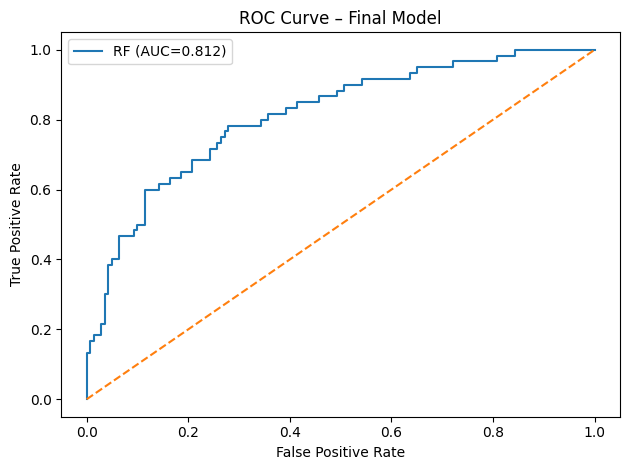

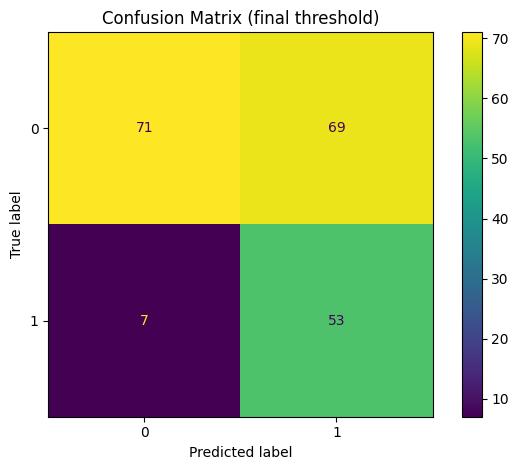

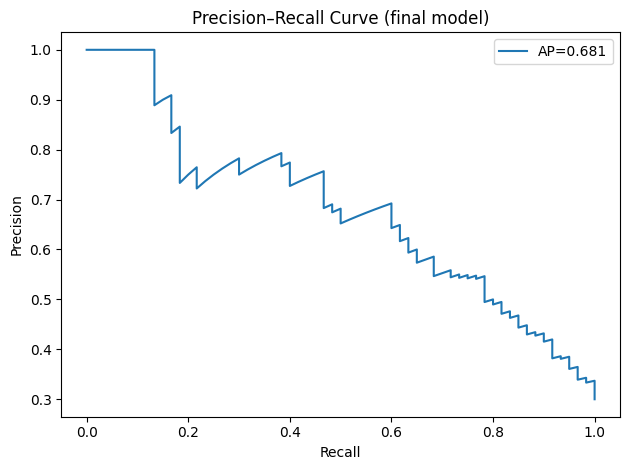

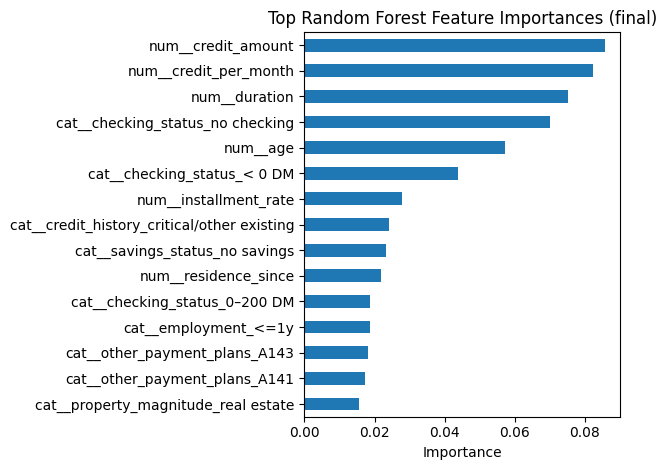

In [2]:
# Extras for chosen model only (plots tie to final_model/chosen_thr)
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, average_precision_score

# ROC (chosen model) — show + save
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"{chosen_name} (AUC={metrics_final['roc_auc']:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final Model")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/roc_final.png", dpi=160)
plt.show()

# Confusion Matrix at final threshold — show + save
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final)
plt.title("Confusion Matrix (final threshold)")
plt.tight_layout()
plt.savefig("outputs/confusion_matrix_final.png", dpi=160)
plt.show()

# Precision–Recall curve — show + save
p, r, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)
plt.figure()
plt.plot(r, p, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (final model)")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/pr_curve_final.png", dpi=160)
plt.show()

# Feature importance / coefficients for chosen model — show + save
feature_names = final_model.named_steps["prep"].get_feature_names_out()
if chosen_name == "LR":
    coef = final_model.named_steps["clf"].coef_.ravel()
    top_idx = (np.abs(coef)).argsort()[-15:]
    ax = pd.Series(coef[top_idx], index=feature_names[top_idx]).sort_values().plot(kind="barh")
    plt.title("Top Logistic Regression Coefficients (final)")
    plt.xlabel("Coefficient"); plt.tight_layout()
    plt.savefig("outputs/top_features_logreg_final.png", dpi=160)
    plt.show()
else:
    rf_est = final_model.named_steps["clf"]
    imp = rf_est.feature_importances_
    top_idx = np.argsort(imp)[-15:]
    pd.Series(imp[top_idx], index=feature_names[top_idx]).sort_values().plot(kind="barh")
    plt.title("Top Random Forest Feature Importances (final)")
    plt.xlabel("Importance"); plt.tight_layout()
    plt.savefig("outputs/top_features_rf_final.png", dpi=160)
    plt.show()


In [3]:
from datetime import date
card = f"""
# Credit Risk Model – Model Card

**Date:** {date.today().isoformat()}
**Dataset:** German Credit (≈1,000 rows)
**Target:** default (1) / good (0)

## Final Selection
- Pipeline: {chosen_name} (with preprocessing)
- Validation-chosen threshold: {metrics_final['threshold']:.3f}
- Test ROC-AUC (threshold 0.5): {metrics_05['roc_auc']:.3f}
- Test Precision/Recall/F1 at final threshold: {metrics_final['precision']:.3f} / {metrics_final['recall']:.3f} / {metrics_final['f1']:.3f}

## Top Drivers
- Coefficients / importances saved in `outputs/` (see feature plots if you kept that section)

## Notes
- Missing values imputed (median numeric, mode categorical)
- Categorical encoded via OneHotEncoder (handle_unknown="ignore")
- Split: 80/20 train/test with stratify; threshold chosen on validation split from train
"""
Path("outputs/model_card.md").write_text(card.strip(), encoding="utf-8")
print("Wrote outputs/model_card.md")


Wrote outputs/model_card.md


In [4]:
print("""
## How to run
1) Create env:  `python -m venv .venv && .venv\\Scripts\\activate`  (macOS/Linux: `source .venv/bin/activate`)
2) Install:     `pip install -r requirements.txt`
3) Place data:  `german_credit_data.csv` next to the notebook.
4) Run:         Execute cells top-to-bottom; artifacts appear in `outputs/`.
5) Inference:   Add `new_applicants.csv` (same columns as training minus target), run the last cell to create `outputs/scored_new_applicants.csv`.
""")


## How to run
1) Create env:  `python -m venv .venv && .venv\Scripts\activate`  (macOS/Linux: `source .venv/bin/activate`)
2) Install:     `pip install -r requirements.txt`
3) Place data:  `german_credit_data.csv` next to the notebook.
4) Run:         Execute cells top-to-bottom; artifacts appear in `outputs/`.
5) Inference:   Add `new_applicants.csv` (same columns as training minus target), run the last cell to create `outputs/scored_new_applicants.csv`.

